# Notes:

v1: used 50 frames from each sequence training dataset for 5 epochs. (tried to use full training dataset, was horrible) 

v2: attempt to use x random frames each epoch in training. Usually more epochs than 5

THIS ONE: 
* v2.1 - 10f - 50 epochs
* v2.1 comparison - 20f - 25 epochs



In [46]:
import torch

import gc
torch.cuda.empty_cache()
gc.collect()

0

In [ ]:
import os
import torch
import torchvision.transforms as T
from PIL import Image
from torchvision.ops import box_convert
import random
from torchvision import transforms

    
class SoccerNetSubsetDataset(torch.utils.data.Dataset):
    def __init__(self, base_dir, frames_per_sequence, transform=None):
        self.base_dir = base_dir
        self.frames_per_sequence = frames_per_sequence
        self.transform = transform if transform else transforms.ToTensor()
        self.samples = []

        self._load_subset_samples()

    def _load_subset_samples(self):
        splits = os.listdir(self.base_dir)
        for seq_name in sorted(splits):
            seq_path = os.path.join(self.base_dir, seq_name)
            img_folder = os.path.join(seq_path, "img1")
            gt_path = os.path.join(seq_path, "gt", "gt.txt")

            if not os.path.exists(img_folder) or not os.path.exists(gt_path):
                continue

            # Load ground truth annotations
            gt_dict = self._load_annotations(gt_path)

            # Collect all image filenames
            all_imgs = sorted([
                f for f in os.listdir(img_folder)
                if f.endswith(".jpg") or f.endswith(".png")
            ])

            # Sample up to frames_per_sequence images
            sampled_imgs = random.sample(all_imgs, min(self.frames_per_sequence, len(all_imgs)))

            for img_name in sampled_imgs:
                frame_id = int(img_name.split(".")[0])
                boxes, labels = gt_dict.get(frame_id, ([], []))
                if boxes:
                    self.samples.append({
                        "img_path": os.path.join(img_folder, img_name),
                        "boxes": boxes,
                        "labels": labels
                    })

    def _load_annotations(self, gt_path):
        gt_dict = {}
        with open(gt_path, "r") as f:
            for line in f:
                parts = line.strip().split(",")
                frame, _, x, y, w, h, cls, _, _ = map(int, parts[:9])
                box = [x, y, x + w, y + h]
                if frame not in gt_dict:
                    gt_dict[frame] = ([], [])
                gt_dict[frame][0].append(box)
                gt_dict[frame][1].append(1)  # Assuming class "1" for player
        return gt_dict

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        image = Image.open(sample["img_path"]).convert("RGB")
        image = self.transform(image)

        boxes = torch.tensor(sample["boxes"], dtype=torch.float32)
        labels = torch.tensor(sample["labels"], dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}
        return image, target

def fix_targets(targets):
    fixed = []
    for target in targets:
        boxes = target["boxes"]
        keep = (boxes[:, 2] > boxes[:, 0]) & (boxes[:, 3] > boxes[:, 1])
        target["boxes"] = boxes[keep]
        target["labels"] = target["labels"][keep]
        fixed.append(target)
    return fixed



In [ ]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import torchvision
import torch
import torchvision.transforms as T
from tqdm import tqdm
from torch.cuda.amp import GradScaler, autocast

# Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.train()

# Freeze backbone except layer4
for name, param in model.backbone.body.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

# Replace prediction head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# ************************************************************* IMORTANT HYPERPARAMETERS
BATCH_SIZE = 4 
EPOCHS = 50#10
FRAMES_PER_SEQ = 10

# Prepare dataset and loader
train_dataset = SoccerNetSubsetDataset("../soccernet_data/tracking/train", frames_per_sequence=FRAMES_PER_SEQ)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler()

# --- Training loop ---
loss_history = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = fix_targets(targets)
        if any(len(t['boxes']) == 0 for t in targets):
            continue

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/50: 100%|██████████| 143/143 [00:52<00:00,  2.74it/s]


Epoch 1 Average Loss: 0.9324


Epoch 2/50: 100%|██████████| 143/143 [00:51<00:00,  2.77it/s]


Epoch 2 Average Loss: 0.7461


Epoch 3/50: 100%|██████████| 143/143 [00:51<00:00,  2.75it/s]


Epoch 3 Average Loss: 0.6880


Epoch 4/50: 100%|██████████| 143/143 [00:51<00:00,  2.75it/s]


Epoch 4 Average Loss: 0.6515


Epoch 5/50: 100%|██████████| 143/143 [00:52<00:00,  2.74it/s]


Epoch 5 Average Loss: 0.6172


Epoch 6/50: 100%|██████████| 143/143 [00:52<00:00,  2.74it/s]


Epoch 6 Average Loss: 0.6016


Epoch 7/50: 100%|██████████| 143/143 [00:52<00:00,  2.73it/s]


Epoch 7 Average Loss: 0.5742


Epoch 8/50: 100%|██████████| 143/143 [00:52<00:00,  2.72it/s]


Epoch 8 Average Loss: 0.5565


Epoch 9/50: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch 9 Average Loss: 0.5323


Epoch 10/50: 100%|██████████| 143/143 [00:52<00:00,  2.71it/s]


Epoch 10 Average Loss: 0.5122


Epoch 11/50: 100%|██████████| 143/143 [00:53<00:00,  2.68it/s]


Epoch 11 Average Loss: 0.4967


Epoch 12/50: 100%|██████████| 143/143 [00:53<00:00,  2.68it/s]


Epoch 12 Average Loss: 0.4795


Epoch 13/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 13 Average Loss: 0.4621


Epoch 14/50: 100%|██████████| 143/143 [00:53<00:00,  2.68it/s]


Epoch 14 Average Loss: 0.4421


Epoch 15/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 15 Average Loss: 0.4257


Epoch 16/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 16 Average Loss: 0.4196


Epoch 17/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 17 Average Loss: 0.3951


Epoch 18/50: 100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


Epoch 18 Average Loss: 0.3853


Epoch 19/50: 100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


Epoch 19 Average Loss: 0.3655


Epoch 20/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 20 Average Loss: 0.3536


Epoch 21/50: 100%|██████████| 143/143 [00:53<00:00,  2.65it/s]


Epoch 21 Average Loss: 0.3364


Epoch 22/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 22 Average Loss: 0.3350


Epoch 23/50: 100%|██████████| 143/143 [00:53<00:00,  2.67it/s]


Epoch 23 Average Loss: 0.3151


Epoch 24/50: 100%|██████████| 143/143 [00:53<00:00,  2.68it/s]


Epoch 24 Average Loss: 0.3031


Epoch 25/50: 100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


Epoch 25 Average Loss: 0.2885


Epoch 26/50: 100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


Epoch 26 Average Loss: 0.3025


Epoch 27/50: 100%|██████████| 143/143 [00:53<00:00,  2.66it/s]


Epoch 27 Average Loss: 0.2863


Epoch 28/50: 100%|██████████| 143/143 [00:54<00:00,  2.65it/s]


Epoch 28 Average Loss: 0.2749


Epoch 29/50: 100%|██████████| 143/143 [00:53<00:00,  2.65it/s]


Epoch 29 Average Loss: 0.2637


Epoch 30/50: 100%|██████████| 143/143 [00:54<00:00,  2.62it/s]


Epoch 30 Average Loss: 0.2649


Epoch 31/50: 100%|██████████| 143/143 [00:54<00:00,  2.62it/s]


Epoch 31 Average Loss: 0.2530


Epoch 32/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]


Epoch 32 Average Loss: 0.2479


Epoch 33/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]


Epoch 33 Average Loss: 0.2411


Epoch 34/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]


Epoch 34 Average Loss: 0.2320


Epoch 35/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 35 Average Loss: 0.2372


Epoch 36/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 36 Average Loss: 0.2277


Epoch 37/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]


Epoch 37 Average Loss: 0.2257


Epoch 38/50: 100%|██████████| 143/143 [00:54<00:00,  2.62it/s]


Epoch 38 Average Loss: 0.2266


Epoch 39/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 39 Average Loss: 0.2198


Epoch 40/50: 100%|██████████| 143/143 [00:54<00:00,  2.62it/s]


Epoch 40 Average Loss: 0.2189


Epoch 41/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 41 Average Loss: 0.2106


Epoch 42/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 42 Average Loss: 0.2103


Epoch 43/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 43 Average Loss: 0.2040


Epoch 44/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]


Epoch 44 Average Loss: 0.1945


Epoch 45/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 45 Average Loss: 0.1961


Epoch 46/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 46 Average Loss: 0.1952


Epoch 47/50: 100%|██████████| 143/143 [00:54<00:00,  2.63it/s]


Epoch 47 Average Loss: 0.1952


Epoch 48/50: 100%|██████████| 143/143 [00:53<00:00,  2.65it/s]


Epoch 48 Average Loss: 0.1954


Epoch 49/50: 100%|██████████| 143/143 [00:53<00:00,  2.65it/s]


Epoch 49 Average Loss: 0.1915


Epoch 50/50: 100%|██████████| 143/143 [00:54<00:00,  2.64it/s]

Epoch 50 Average Loss: 0.1841


In [14]:
# Save
version = "v2.1-10frames50epoch"
os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), f"weights/fasterrcnn_soccernet_finetuned_{version}.pth")

# Load
# model.load_state_dict(torch.load("fasterrcnn_soccernet_finetuned.pth"))


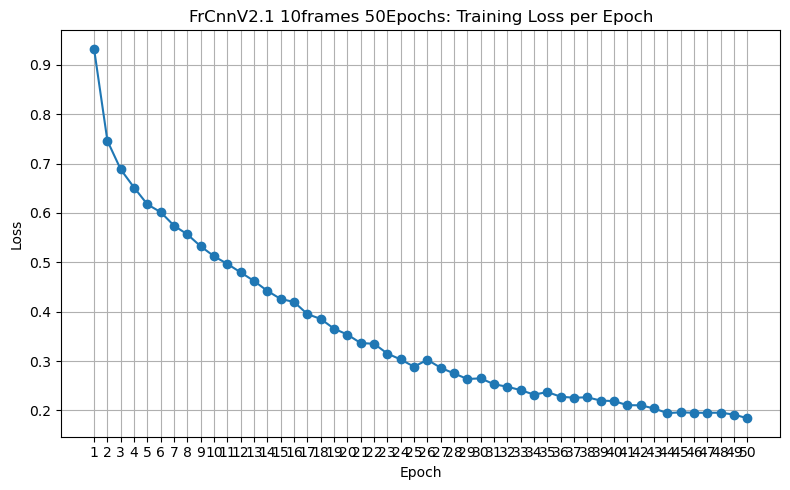

In [17]:
import matplotlib.pyplot as plt

titleStr = "FrCnnV2.1 10frames 50Epochs"
def plot_epoch_losses(epoch_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
    plt.title(f"{titleStr}: Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.xticks(range(1, len(epoch_losses) + 1))
    plt.tight_layout()
    plt.show()

plot_epoch_losses(loss_history)



# evaluation for thresholds -> 0.8, 0.5

In [18]:
from collections import defaultdict
from torchvision.utils import draw_bounding_boxes

# --- CONFIG ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DATA_DIR = "../soccernet_data/tracking/test"
GT_FILENAME = "gt.txt"
IMAGE_FOLDER = "img1"
IMAGE_EXTS = ['.jpg', '.png']
NUM_OUTPUT_SAMPLE_IMAGES = 10

# ************************************************************* IMORTANT HYPERPARAMETERS
SCORE_THRESH = 0.8
IOU_THRESH = 0.5

model.eval()
model.to(device)

# --- IMAGE PREPROCESSING ---
transform = T.Compose([
    T.ToTensor(),
])

def load_gt_boxes(gt_path):
    gt_dict = defaultdict(list)
    if not os.path.exists(gt_path):
        return gt_dict
    with open(gt_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            frame, _, x, y, w, h, cls, _, _ = map(int, parts[:9])
            box = torch.tensor([x, y, x + w, y + h], device=device)
            gt_dict[frame].append(box)
    return gt_dict

# --- IOU CALCULATION ---
def compute_iou(box1, box2):
    if box1.size(0) == 0 or box2.size(0) == 0:
        return torch.zeros((box1.size(0), box2.size(0)), device=box1.device)
    area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])
    area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])
    lt = torch.max(box1[:, None, :2], box2[:, :2])
    rb = torch.min(box1[:, None, 2:], box2[:, 2:])
    wh = (rb - lt).clamp(min=0)
    inter = wh[:, :, 0] * wh[:, :, 1]
    union = area1[:, None] + area2 - inter
    iou = inter / union
    return iou

# --- DRAW DETECTIONS + GT ---
def plot_gt_and_detections(image_tensor, detections, gt_boxes, score_thresh=0.8):
    boxes = detections['boxes']
    scores = detections['scores']
    keep = scores > score_thresh
    pred_boxes = boxes[keep]

    all_boxes = []
    labels = []
    colors = []

    for box in pred_boxes:
        all_boxes.append(box)
        labels.append("pred")
        colors.append("red")

    for box in gt_boxes:
        all_boxes.append(box)
        labels.append("gt")
        colors.append("green")

    if len(all_boxes) == 0:
        return T.ToPILImage()(image_tensor)

    all_boxes_tensor = torch.stack(all_boxes).to("cpu")
    drawn = draw_bounding_boxes(
        (image_tensor * 255).byte().cpu(),
        boxes=all_boxes_tensor,
        labels=labels,
        colors=colors,
        width=2
    )
    return T.ToPILImage()(drawn)

import random

sequence_usage_frame_count = 30

print("Using device:", DEVICE)
print("Number of images to sample:", NUM_OUTPUT_SAMPLE_IMAGES)
print("Score threshold:", SCORE_THRESH)
print("IOU threshold:", IOU_THRESH)

Using device: cuda
Number of images to sample: 10
Score threshold: 0.8
IOU threshold: 0.5


# Evaluated on Testing data

In [48]:


# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0


# Only use test sequences
seq_dirs = []
test_dir = os.path.join("../soccernet_data/tracking", "test")
if os.path.exists(test_dir):
    for d in sorted(os.listdir(test_dir)):
        full_path = os.path.join(test_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append(("test", d))



print("Processing sequences...")
# Get 30 random frames from each sequence
for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join("../soccernet_data/tracking", split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)  # Shuffle to get random frames
    all_img_paths = all_img_paths[:sequence_usage_frame_count]  # Sample random frames from each sequence

    for idx, path in enumerate(all_img_paths):
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping corrupted image: {path} | Error: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        filename = os.path.basename(path)

        try:
            frame_id = int(filename.split('.')[0])
        except ValueError:
            continue
        
        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            output = model(img_tensor.to(DEVICE))[0]

        pred_boxes = output['boxes'][output['scores'] > SCORE_THRESH]


        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)


        # Precision / Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Sampled frames
        if len(sample_frames) < NUM_OUTPUT_SAMPLE_IMAGES and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor[0], output, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))

# --- DISPLAY SUMMARY ---
print(f"Number of sampled frames to output: {len(sample_frames)}")
print(f"Total frames processed: {len(results)}")

print("Final metrics:")
# Final metrics
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} frames: {avg_acc * 100:.2f}%")



Processing sequences...


Sequences: 100%|██████████| 49/49 [02:13<00:00,  2.72s/it]

Number of sampled frames to output: 10
Total frames processed: 1470
Final metrics:

Average Detection Accuracy over 1470 frames: 91.80%
Precision: 0.910, Recall: 0.897 frames: 91.80%


In [49]:

# --- SHOW EXAMPLES ---
# for seq_id, filename, img in sample_frames:
#     plt.imshow(img)
#     plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
#     plt.axis("off")
#     plt.show()

# Save sample frames
# os.makedirs("sample_frames", exist_ok=True)
os.makedirs("8-5-score-iou-threshold/8-5-frcnn-v2.1_10f_50e-new", exist_ok=True)
for seq_id, filename, img in sample_frames:
    img.save(os.path.join("8-5-score-iou-threshold/8-5-frcnn-v2.1_10f_50e-new", f"{seq_id}_{filename}"))

# Save metrics
# os.makedirs("metrics", exist_ok=True)
with open("8-5-score-iou-threshold/8-5-frcnn-v2.1_10f_50e-new/metrics.txt", "w") as f:
    f.write(f"Score Threshold: {SCORE_THRESH}\n")
    f.write(f"IOU Threshold: {IOU_THRESH}\n")
    f.write(f"Total frames processed: {len(results)}\n")
    f.write(f"Average Detection Accuracy: {avg_acc * 100:.2f}%\n")
    f.write(f"Precision: {precision:.3f}, Recall: {recall:.3f}\n")
    f.write(f"Total TP: {total_tp}, Total FP: {total_fp}, Total FN: {total_fn}\n")





# evaluation for thresholds -> 0.5, 0.5

In [ ]:
# ************************************************************* IMORTANT HYPERPARAMETERS
SCORE_THRESH = 0.5
IOU_THRESH = 0.5

# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0


# Only use test sequences
seq_dirs = []
test_dir = os.path.join("../soccernet_data/tracking", "test")
if os.path.exists(test_dir):
    for d in sorted(os.listdir(test_dir)):
        full_path = os.path.join(test_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append(("test", d))



print("Processing sequences...")
# Get 30 random frames from each sequence
for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join("../soccernet_data/tracking", split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)  # Shuffle to get random frames
    all_img_paths = all_img_paths[:sequence_usage_frame_count]  # Sample random frames from each sequence

    for idx, path in enumerate(all_img_paths):
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping corrupted image: {path} | Error: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        filename = os.path.basename(path)

        try:
            frame_id = int(filename.split('.')[0])
        except ValueError:
            continue
        
        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            output = model(img_tensor.to(DEVICE))[0]

        pred_boxes = output['boxes'][output['scores'] > SCORE_THRESH]


        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)


        # Precision / Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Sampled frames
        if len(sample_frames) < NUM_OUTPUT_SAMPLE_IMAGES and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor[0], output, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))

# --- DISPLAY SUMMARY ---
print(f"Number of sampled frames to output: {len(sample_frames)}")
print(f"Total frames processed: {len(results)}")

print("Final metrics:")
# Final metrics
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} frames: {avg_acc * 100:.2f}%")



Processing sequences...


Sequences: 100%|██████████| 49/49 [02:10<00:00,  2.67s/it]

Number of sampled frames to output: 10
Total frames processed: 1470
Final metrics:

Average Detection Accuracy over 1470 frames: 93.09%
Precision: 0.918, Recall: 0.918 frames: 93.09%


In [28]:

# --- SHOW EXAMPLES ---
# for seq_id, filename, img in sample_frames:
#     plt.imshow(img)
#     plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
#     plt.axis("off")
#     plt.show()

# Save sample frames
# os.makedirs("sample_frames", exist_ok=True)
# os.path.exists("5-5-frcnn-v2.1_10f_50e") or os.makedirs("5-5-frcnn-v2.1_10f_50e")
os.path.exists("5-5-score-iou-threshold/5-5-frcnn-v2.1_10f_50e") or os.makedirs("5-5-score-iou-threshold/5-5-frcnn-v2.1_10f_50e")
for seq_id, filename, img in sample_frames:
    img.save(os.path.join("5-5-score-iou-threshold/5-5-frcnn-v2.1_10f_50e", f"{seq_id}_{filename}"))

# Save metrics
# os.makedirs("metrics", exist_ok=True)
with open("5-5-score-iou-threshold/5-5-frcnn-v2.1_10f_50e/metrics.txt", "w") as f:
    f.write(f"Score Threshold: {SCORE_THRESH}\n")
    f.write(f"IOU Threshold: {IOU_THRESH}\n")
    f.write(f"Total frames processed: {len(results)}\n")
    f.write(f"Average Detection Accuracy: {avg_acc * 100:.2f}%\n")
    f.write(f"Precision: {precision:.3f}, Recall: {recall:.3f}\n")
    f.write(f"Total TP: {total_tp}, Total FP: {total_fp}, Total FN: {total_fn}\n")





# Training for 20 frames and 25 epochs 
for -> frcnn-v2.1_20f_25e

In [ ]:

# Load model
model = fasterrcnn_resnet50_fpn(pretrained=True)
model.train()

# Freeze backbone except layer4
for name, param in model.backbone.body.named_parameters():
    if "layer4" not in name:
        param.requires_grad = False

# Replace prediction head
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# ************************************************************* IMORTANT HYPERPARAMETERS
BATCH_SIZE = 4 
EPOCHS = 25#10
FRAMES_PER_SEQ = 20

# Prepare dataset and loader
train_dataset = SoccerNetSubsetDataset("../soccernet_data/tracking/train", frames_per_sequence=FRAMES_PER_SEQ)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

# Optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler()

# --- Training loop ---
loss_history = []
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    for images, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        targets = fix_targets(targets)
        if any(len(t['boxes']) == 0 for t in targets):
            continue

        optimizer.zero_grad()
        with autocast():
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        scaler.scale(losses).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += losses.item()

    avg_loss = total_loss / len(train_loader)
    loss_history.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")


/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bada/anaconda3/envs/practice/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Epoch 1/25: 100%|██████████| 285/285 [01:45<00:00,  2.70it/s]


Epoch 1 Average Loss: 0.8651


Epoch 2/25: 100%|██████████| 285/285 [01:43<00:00,  2.74it/s]


Epoch 2 Average Loss: 0.7316


Epoch 3/25: 100%|██████████| 285/285 [01:44<00:00,  2.73it/s]


Epoch 3 Average Loss: 0.6707


Epoch 4/25: 100%|██████████| 285/285 [01:44<00:00,  2.72it/s]


Epoch 4 Average Loss: 0.6307


Epoch 5/25: 100%|██████████| 285/285 [01:45<00:00,  2.70it/s]


Epoch 5 Average Loss: 0.5993


Epoch 6/25: 100%|██████████| 285/285 [01:45<00:00,  2.70it/s]


Epoch 6 Average Loss: 0.5810


Epoch 7/25: 100%|██████████| 285/285 [01:47<00:00,  2.66it/s]


Epoch 7 Average Loss: 0.5534


Epoch 8/25: 100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch 8 Average Loss: 0.5334


Epoch 9/25: 100%|██████████| 285/285 [01:47<00:00,  2.64it/s]


Epoch 9 Average Loss: 0.5145


Epoch 10/25: 100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch 10 Average Loss: 0.4977


Epoch 11/25: 100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch 11 Average Loss: 0.4793


Epoch 12/25: 100%|██████████| 285/285 [01:49<00:00,  2.61it/s]


Epoch 12 Average Loss: 0.4582


Epoch 13/25: 100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch 13 Average Loss: 0.4413


Epoch 14/25: 100%|██████████| 285/285 [01:48<00:00,  2.62it/s]


Epoch 14 Average Loss: 0.4241


Epoch 15/25: 100%|██████████| 285/285 [01:48<00:00,  2.63it/s]


Epoch 15 Average Loss: 0.4079


Epoch 16/25: 100%|██████████| 285/285 [01:47<00:00,  2.65it/s]


Epoch 16 Average Loss: 0.3892


Epoch 17/25: 100%|██████████| 285/285 [01:47<00:00,  2.65it/s]


Epoch 17 Average Loss: 0.3857


Epoch 18/25: 100%|██████████| 285/285 [01:47<00:00,  2.66it/s]


Epoch 18 Average Loss: 0.3665


Epoch 19/25: 100%|██████████| 285/285 [01:47<00:00,  2.66it/s]


Epoch 19 Average Loss: 0.3516


Epoch 20/25: 100%|██████████| 285/285 [01:46<00:00,  2.66it/s]


Epoch 20 Average Loss: 0.3357


Epoch 21/25: 100%|██████████| 285/285 [01:47<00:00,  2.66it/s]


Epoch 21 Average Loss: 0.3287


Epoch 22/25: 100%|██████████| 285/285 [01:46<00:00,  2.67it/s]


Epoch 22 Average Loss: 0.3195


Epoch 23/25: 100%|██████████| 285/285 [01:46<00:00,  2.67it/s]


Epoch 23 Average Loss: 0.3033


Epoch 24/25: 100%|██████████| 285/285 [01:47<00:00,  2.66it/s]


Epoch 24 Average Loss: 0.2984


Epoch 25/25: 100%|██████████| 285/285 [01:46<00:00,  2.67it/s]

Epoch 25 Average Loss: 0.2871


In [32]:
# frcnn-v2.1_20f_25e

# Save
version = "v2.1-20frames25epoch"
os.makedirs("weights", exist_ok=True)
torch.save(model.state_dict(), f"weights/fasterrcnn_soccernet_finetuned_{version}.pth")

# Load
# model.load_state_dict(torch.load("fasterrcnn_soccernet_finetuned.pth"))



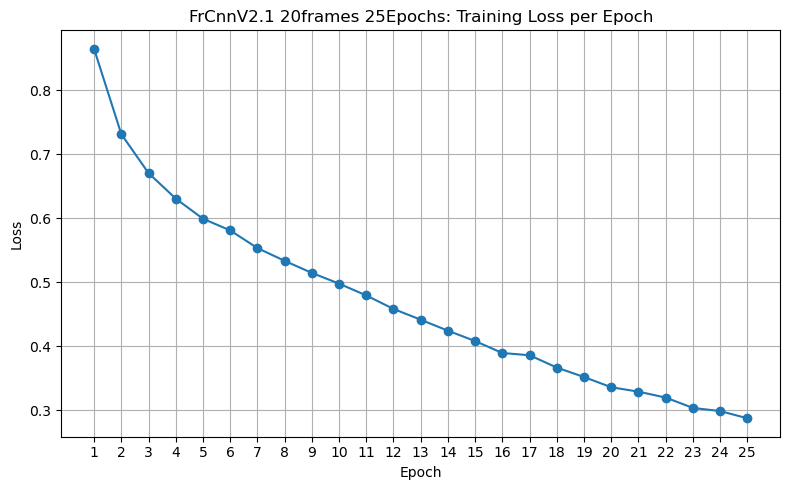

In [31]:
import matplotlib.pyplot as plt

titleStr = "FrCnnV2.1 20frames 25Epochs"
def plot_epoch_losses(epoch_losses):
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, len(epoch_losses) + 1), epoch_losses, marker='o', linestyle='-')
    plt.title(f"{titleStr}: Training Loss per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.xticks(range(1, len(epoch_losses) + 1))
    plt.tight_layout()
    plt.show()

plot_epoch_losses(loss_history)



# evaluation for thresholds -> 0.8, 0.5

# Evaluate on testing data

In [33]:

# --- CONFIG ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BASE_DATA_DIR = "../soccernet_data/tracking/test"
GT_FILENAME = "gt.txt"
IMAGE_FOLDER = "img1"
IMAGE_EXTS = ['.jpg', '.png']
NUM_OUTPUT_SAMPLE_IMAGES = 10
SCORE_THRESH = 0.8
IOU_THRESH = 0.5

model.eval()
model.to(device)


sequence_usage_frame_count = 30

print("Using device:", DEVICE)
print("Number of images to sample:", NUM_OUTPUT_SAMPLE_IMAGES)
print("Score threshold:", SCORE_THRESH)
print("IOU threshold:", IOU_THRESH)

Using device: cuda
Number of images to sample: 10
Score threshold: 0.8
IOU threshold: 0.5


In [50]:

# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0


# Only use test sequences
seq_dirs = []
test_dir = os.path.join("../soccernet_data/tracking", "test")
if os.path.exists(test_dir):
    for d in sorted(os.listdir(test_dir)):
        full_path = os.path.join(test_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append(("test", d))



print("Processing sequences...")
# Get 30 random frames from each sequence
for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join("../soccernet_data/tracking", split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)  # Shuffle to get random frames
    all_img_paths = all_img_paths[:sequence_usage_frame_count]  # Sample random frames from each sequence

    for idx, path in enumerate(all_img_paths):
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping corrupted image: {path} | Error: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        filename = os.path.basename(path)

        try:
            frame_id = int(filename.split('.')[0])
        except ValueError:
            continue
        
        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            output = model(img_tensor.to(DEVICE))[0]

        pred_boxes = output['boxes'][output['scores'] > SCORE_THRESH]


        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)


        # Precision / Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Sampled frames
        if len(sample_frames) < NUM_OUTPUT_SAMPLE_IMAGES and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor[0], output, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))

# --- DISPLAY SUMMARY ---
print(f"Number of sampled frames to output: {len(sample_frames)}")
print(f"Total frames processed: {len(results)}")

print("Final metrics:")
# Final metrics
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} frames: {avg_acc * 100:.2f}%")



Processing sequences...


Sequences: 100%|██████████| 49/49 [02:13<00:00,  2.73s/it]

Number of sampled frames to output: 10
Total frames processed: 1470
Final metrics:

Average Detection Accuracy over 1470 frames: 92.02%
Precision: 0.911, Recall: 0.898 frames: 92.02%


In [51]:

# --- SHOW EXAMPLES ---
# for seq_id, filename, img in sample_frames:
#     plt.imshow(img)
#     plt.title(f"Sequence {seq_id}, Frame {filename}\nRed = Prediction, Green = Ground Truth")
#     plt.axis("off")
#     plt.show()

# Save sample frames
# os.makedirs("sample_frames", exist_ok=True)
os.makedirs("8-5-score-iou-threshold/8-5-frcnn-v2.1_20f_25e-new", exist_ok=True)
for seq_id, filename, img in sample_frames:
    img.save(os.path.join("8-5-score-iou-threshold/8-5-frcnn-v2.1_20f_25e-new", f"{seq_id}_{filename}"))

# Save metrics
# os.makedirs("metrics", exist_ok=True)
with open("8-5-score-iou-threshold/8-5-frcnn-v2.1_20f_25e-new/metrics.txt", "w") as f:
    f.write(f"Score Threshold: {SCORE_THRESH}\n")
    f.write(f"IOU Threshold: {IOU_THRESH}\n")
    f.write(f"Total frames processed: {len(results)}\n")
    f.write(f"Average Detection Accuracy: {avg_acc * 100:.2f}%\n")
    f.write(f"Precision: {precision:.3f}, Recall: {recall:.3f}\n")
    f.write(f"Total TP: {total_tp}, Total FP: {total_fp}, Total FN: {total_fn}\n")





# evaluation for thresholds -> 0.5, 0.5

In [ ]:
SCORE_THRESH = 0.5
IOU_THRESH = 0.5
# --- EXECUTION ---
results = []
sample_frames = []
total_tp = total_fp = total_fn = 0


# Only use test sequences
seq_dirs = []
test_dir = os.path.join("../soccernet_data/tracking", "test")
if os.path.exists(test_dir):
    for d in sorted(os.listdir(test_dir)):
        full_path = os.path.join(test_dir, d)
        if os.path.isdir(full_path):
            seq_dirs.append(("test", d))



print("Processing sequences...")
# Get 30 random frames from each sequence
for split, seq_id in tqdm(seq_dirs, desc="Sequences", dynamic_ncols=True):
    seq_path = os.path.join("../soccernet_data/tracking", split, seq_id)
    img_dir = os.path.join(seq_path, IMAGE_FOLDER)
    gt_path = os.path.join(seq_path, "gt", GT_FILENAME)
    gt_dict = load_gt_boxes(gt_path)

    if not os.path.exists(img_dir):
        continue

    all_img_paths = sorted([
        os.path.join(img_dir, file)
        for file in os.listdir(img_dir)
        if any(file.lower().endswith(ext) for ext in IMAGE_EXTS)
    ])

    random.shuffle(all_img_paths)  # Shuffle to get random frames
    all_img_paths = all_img_paths[:sequence_usage_frame_count]  # Sample random frames from each sequence

    for idx, path in enumerate(all_img_paths):
        try:
            img = Image.open(path).convert("RGB")
        except Exception as e:
            print(f"Skipping corrupted image: {path} | Error: {e}")
            continue

        img_tensor = transform(img).unsqueeze(0).to(DEVICE)
        filename = os.path.basename(path)

        try:
            frame_id = int(filename.split('.')[0])
        except ValueError:
            continue
        
        gt_boxes = gt_dict.get(frame_id, [])

        with torch.no_grad():
            output = model(img_tensor.to(DEVICE))[0]

        pred_boxes = output['boxes'][output['scores'] > SCORE_THRESH]


        # Accuracy
        if gt_boxes:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            if len(pred_boxes) > 0:
                ious = compute_iou(pred_boxes, gt_tensor)
                max_ious = ious.max(dim=1)[0]
                acc = (max_ious > IOU_THRESH).float().mean().item()
            else:
                acc = 0.0
        else:
            acc = 1.0 if len(pred_boxes) == 0 else 0.0

        results.append(acc)


        # Precision / Recall
        matched_gt = set()
        tp = fp = 0
        if len(pred_boxes) > 0 and len(gt_boxes) > 0:
            gt_tensor = torch.stack(gt_boxes).to(DEVICE)
            ious = compute_iou(pred_boxes, gt_tensor)
            for i in range(len(pred_boxes)):
                max_iou, gt_idx = ious[i].max(0)
                if max_iou > IOU_THRESH and gt_idx.item() not in matched_gt:
                    tp += 1
                    matched_gt.add(gt_idx.item())
                else:
                    fp += 1
        else:
            tp = 0
            fp = len(pred_boxes)

        fn = len(gt_boxes) - len(matched_gt)
        total_tp += tp
        total_fp += fp
        total_fn += fn

        # Sampled frames
        if len(sample_frames) < NUM_OUTPUT_SAMPLE_IMAGES and seq_id not in [s[0] for s in sample_frames]:
            img_vis = plot_gt_and_detections(img_tensor[0], output, gt_boxes)
            sample_frames.append((seq_id, filename, img_vis))

# --- DISPLAY SUMMARY ---
print(f"Number of sampled frames to output: {len(sample_frames)}")
print(f"Total frames processed: {len(results)}")

print("Final metrics:")
# Final metrics
precision = total_tp / (total_tp + total_fp + 1e-6)
recall = total_tp / (total_tp + total_fn + 1e-6)
avg_acc = sum(results) / len(results) if results else 0
print(f"\nAverage Detection Accuracy over {len(results)} frames: {avg_acc * 100:.2f}%")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f} frames: {avg_acc * 100:.2f}%")



Processing sequences...


Sequences: 100%|██████████| 49/49 [02:11<00:00,  2.68s/it]

Number of sampled frames to output: 10
Total frames processed: 1470
Final metrics:

Average Detection Accuracy over 1470 frames: 93.66%
Precision: 0.925, Recall: 0.923 frames: 93.66%


In [43]:

# Save sample frames

for seq_id, filename, img in sample_frames:
    img.save(os.path.join("5-5-score-iou-threshold/5-5-frcnn-v2.1_20f_25e", f"{seq_id}_{filename}"))

# Save metrics
# os.makedirs("metrics", exist_ok=True)
with open("5-5-score-iou-threshold/5-5-frcnn-v2.1_20f_25e/metrics.txt", "w") as f:
    f.write(f"Score Threshold: {SCORE_THRESH}\n")
    f.write(f"IOU Threshold: {IOU_THRESH}\n")
    f.write(f"Total frames processed: {len(results)}\n")
    f.write(f"Average Detection Accuracy: {avg_acc * 100:.2f}%\n")
    f.write(f"Precision: {precision:.3f}, Recall: {recall:.3f}\n")
    f.write(f"Total TP: {total_tp}, Total FP: {total_fp}, Total FN: {total_fn}\n")



